## ANALYSIS EXPERIMENT 2.2 (GPT2-SMALL)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import importlib
import os


import sys
# custom path insertion
sys.path.append(os.path.abspath('..'))

import utils 
importlib.reload(utils)

from utils import *

[2024-09-17 14:38:51,781] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.


/opt/anaconda/anaconda3/envs/elias/compiler_compat/ld: /tmp/tmp6au4jd9d/test.o: in function `main':
/tmp/tmp6au4jd9d/test.c:1: undefined reference to `io_pgetevents'
collect2: error: ld returned 1 exit status


 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectures
 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


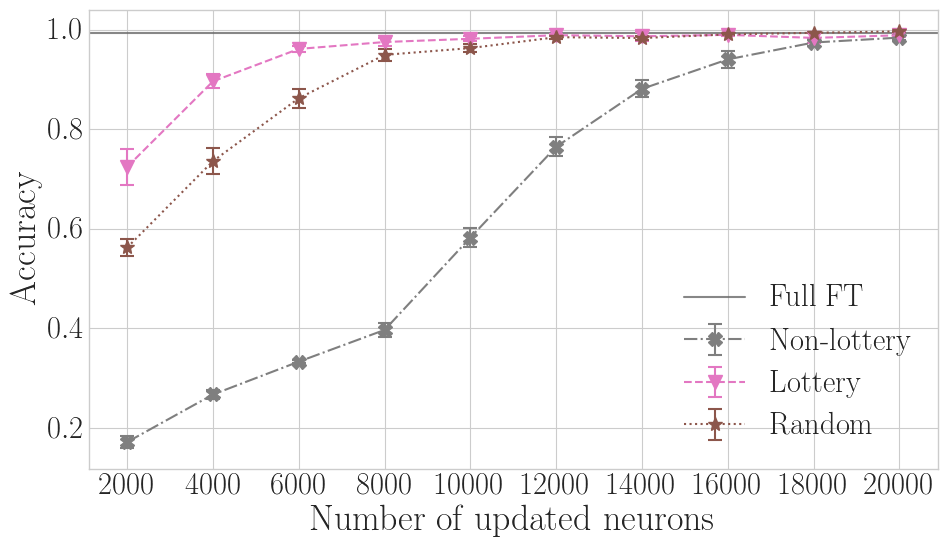

In [2]:
%load_ext autoreload
%autoreload 2

from retained_plots import plot_new_knowledge_all


experiment_name = 'experiment_2_2'
filepath = '../results/experiment_2_2'
filename = 'experiment_2_2_1000.json'

plot_new_knowledge_all(filepath, filename, experiment_name, loc_new='lower right', bbox_new=(1,0))

In [2]:
with open('../results/experiment_2_2/experiment_2_2_1000.json', 'r') as file: 
    data = json.load(file)

#### Accuracy plot

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n_folds =  len(data['results'].keys())
n_thresh = len(list(data['results'].values())[0]['cfta'].keys())


# Initialize accumulators for standard deviation calculations
cftb_stub_accB_list = np.zeros((n_folds, n_thresh))
cftb_free_accB_list = np.zeros((n_folds, n_thresh))
cftb_rnd_accB_list = np.zeros((n_folds, n_thresh))

ftb_accB = 0

for i, fold in enumerate(data['results']):
    ftb_accB += data['results'][fold]['fta']['acc_A']

    cftb_results = data['results'][fold]['cfta']

    cftb_stub_accB_list[i, :] = np.array([cftb_results[t]['busy_H']['avg_accA'] for t in cftb_results]).astype(float)
    cftb_free_accB_list[i, :] = np.array([cftb_results[t]['free_H']['avg_accA'] for t in cftb_results]).astype(float)
    cftb_rnd_accB_list[i, :] = np.array([cftb_results[t]['rnd']['avg_accA'] for t in cftb_results]).astype(float)

ftb_accB /= n_folds
cftb_stub_accB = np.mean(cftb_stub_accB_list, axis=0)
cftb_free_accB = np.mean(cftb_free_accB_list, axis=0)
cftb_rnd_accB = np.mean(cftb_rnd_accB_list, axis=0)

# Calculate standard deviations
cftb_stub_accB_std = np.std(cftb_stub_accB_list, axis=0)
cftb_free_accB_std = np.std(cftb_free_accB_list, axis=0)
cftb_rnd_accB_std = np.std(cftb_rnd_accB_list, axis=0)

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Creating custom x labels
x_labels = list(cftb_results.keys())

# Plotting with error bars
axs.axhline(y=ftb_accB, color='firebrick', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full fine-tuning')
axs.errorbar(x_labels, cftb_free_accB, yerr=cftb_free_accB_std, linestyle='-', color='tab:blue', marker='.', capsize=2, elinewidth=1, capthick=1, label='Free neurons')
axs.errorbar(x_labels, cftb_stub_accB, yerr=cftb_stub_accB_std, linestyle='--', color='tab:green', marker='.',capsize=2, elinewidth=1, capthick=1, label='Busy neurons')
axs.errorbar(x_labels, cftb_rnd_accB, yerr=cftb_rnd_accB_std, linestyle=':', color='tab:purple', marker='.',capsize=2, elinewidth=1, capthick=1, label='Sparse neurons (random)')

axs.set_xlabel('Number of updated neurons')
axs.set_ylabel('Accuracy')
# axs.set_title('Local fine-tuning - Accuracy Set A')
axs.legend(loc='lower right')
axs.grid(True)

plt.tight_layout()

# Display the plot
plt.show()

#### Distribution of busy neurons across layers

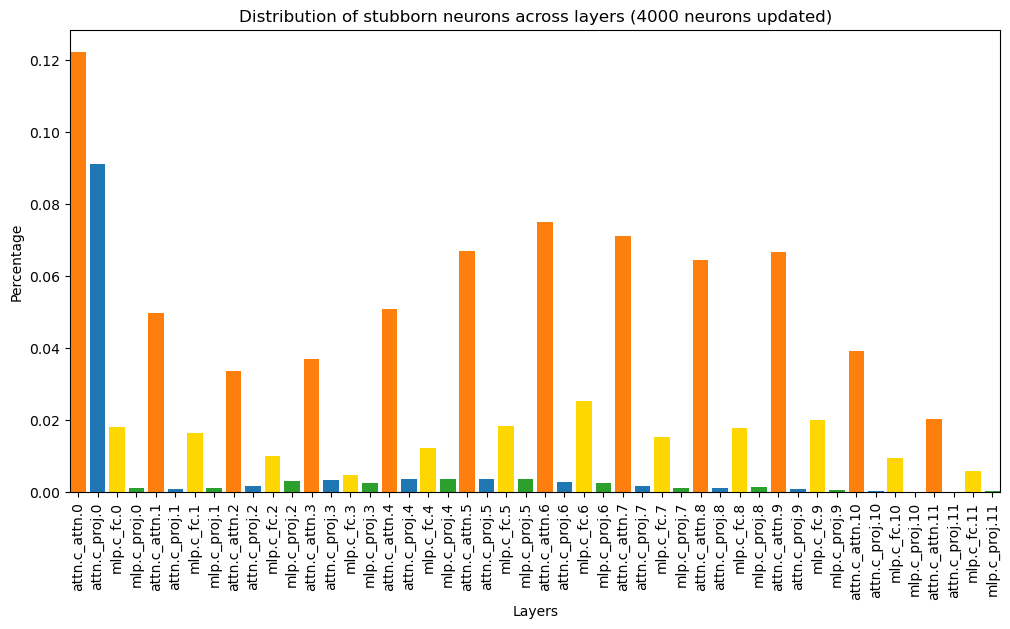

In [18]:
t=4000

# Sample dictionary with numpy arrays as values
data, num_neurons, count = stubborn_extraction(
    historical_path='../experiments/gpt2-small/experiment_2/historical_data.pkl',
    norm=False,
    threshold=0,
    inverse=True,
    num_threshold=t,
    return_stubborn=False
    )

x_labels = [f"{k.split('.')[-2]}.{k.split('.')[-1]}.{k.split('.')[-3]}" for k in data.keys()]

# Extract the lengths of the numpy arrays
lengths = [(len(v[0]))/t for v in data.values()]

# Define the repeating color pattern
colors = ['tab:orange', 'tab:blue', 'gold', 'tab:green']

# Create the histogram
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(lengths)), lengths, color=[colors[i % len(colors)] for i in range(len(lengths))])

# Add labels and title
ax.set_xlabel('Layers')
ax.set_ylabel(f'Percentage')
ax.set_title(f'Distribution of stubborn neurons across layers ({t} neurons updated)')
ax.set_xticks(range(len(data)))
ax.set_xticklabels(x_labels)

# Rotate x-axis labels to be vertical
plt.xticks(rotation=90)

# Adjust the spacing between bars
ax.margins(x=0.000001)

# Display the plot
plt.show()